<a href="https://colab.research.google.com/github/castrokelly/Data-Science/blob/main/Po%C3%A7os_27_e_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abordagem Ensemble para Detecção e Classificação de Anomalias em Poços de Petróleo: um Estudo Aplicado ao Dataset 3W

**Centro de Ciências Matemáticas Aplicadas à Indústria (CeMEAI)**</br>
**Instituto de Ciências Matemáticas e de Computação (ICMC)**</br>
**Universidade de São Paulo**</br>
</br>
Aluna: **Kelly Christine Alvarenga de Castro**
Área de concentração: Ciências de Dados
Orientador: **Prof. Dr. Cláudio Fabiano Motta Toledo**
</br>
---

**Evento:** Formação de hidratos na linha de produção  
**Dados Utilizados:**
**Poço 27** (treinamento e teste): `/content/3W/dataset/8/WELL-00027_20230918170106.parquet`

**Poço 28** (validação): `/content/3W/dataset/8/WELL-00028_20210617053128.parquet`</br>

**Abordagem:**
* 1. Carregar os dados e remover colunas indesejadas.
* 2. Segmentar (`windowing`) os dados em janelas de **2100** linhas (35 minutos).
* 3. Agregar as features estatísticas de cada janela e definir o rótulo (usando o valor máximo de "class") e a flag `"is_anomaly"`.
* 4. Pré-processar os dados (remoção de colunas com `NA` nos sensores, eliminação de features com variância zero, normalização e PCA).
* 5. Dividir as janelas do Poço 27 em treino (70%) e teste (30%) e balancear o conjunto de treinamento.
* 6. Definir os modelos: Random Forest, Gradient Boosting e um modelo LSTM (adaptado para receber dados 2D e fazer reshape interno).
* 7. Integrar os modelos via `StackingClassifier` e avaliar o desempenho nos dados de Poço 27 e na validação do Poço 28.

**Observação:** Usamos uma classe personalizada `CustomKerasClassifier` para sobrescrever `_get_tags`, contornando um erro relacionado a `__sklearn_tags__`.

Clonagem do repositório contendo o dataset 3W e instalação das bibliotecas necessárias:

In [19]:
!git clone https://github.com/petrobras/3W.git

fatal: destination path '3W' already exists and is not an empty directory.


Importação das bibliotecas necessárias para manipulação dos dados, pré-processamento, construção e avaliação dos modelos:

In [20]:
!pip install --upgrade scikeras scikit-learn


  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)


In [53]:
import os
import numpy as np
import pandas as pd
import pywt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc

!pip install imblearn -q
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, LSTM, Dense, Dropout
from scikeras.wrappers import KerasClassifier

import matplotlib.pyplot as plt
%matplotlib inline


### Funções para Carregamento e Pré-processamento dos Dados

Carregamento dos Dados

Estas funções carregam os dados, removem as colunas indesejadas, fazem o windowing (segmentação) e agregam as features.

In [34]:
def load_well_data(file_path):
    """Carrega um arquivo Parquet."""
    return pd.read_parquet(file_path)

def remove_columns(df, cols_to_drop):
    """Remove as colunas especificadas do DataFrame."""
    return df.drop(columns=cols_to_drop, errors='ignore')

def window_data(df, window_size):
    """
    Divide o DataFrame em janelas não sobrepostas de tamanho window_size (número de linhas).
    Cada janela recebe um identificador único na coluna 'instance'.
    Se o DataFrame tiver menos linhas que window_size, retorna-o como uma única janela.
    """
    windows = []
    num_rows = df.shape[0]
    if num_rows < window_size:
        df = df.copy()
        df['instance'] = "window_0"
        return df
    for start in range(0, num_rows, window_size):
        window = df.iloc[start:start+window_size].copy()
        if len(window) < window_size:
            continue
        window['instance'] = f"window_{start}"
        windows.append(window)
    return pd.concat(windows, ignore_index=True) if windows else pd.DataFrame()


In [35]:
def aggregate_features(df, sensor_cols):
    """
    Para cada janela (definida pela coluna 'instance'), calcula:
    - Média, desvio padrão, mínimo e máximo para cada sensor.
    - Para a coluna 'class', utiliza o valor máximo da janela.
    Define 'is_anomaly' como 0 se todos os valores de 'class' forem 0; caso contrário, 1.
    """
    agg_funcs = ['mean', 'std', 'min', 'max']
    agg_df = df.groupby('instance')[sensor_cols].agg(agg_funcs)
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]

    classes = df.groupby('instance')['class'].max()
    is_anomaly = df.groupby('instance')['class'].apply(lambda x: 0 if (x==0).all() else 1)

    agg_df['class'] = classes
    agg_df['is_anomaly'] = is_anomaly
    return agg_df

Carregando os dados dos poços:

In [24]:
cols_to_drop = ["T-PDG", "T-JUS-CKP", "QBS", "PT-P", "P-PDG", "P-MON-SDV-P",
                "P-JUS-CKP", "P-MON-CKGL", "P-JUS-BS", "P-ANULAR", "ESTADO-DHSV","ABER-CKGL", "ABER-CKP"]

file_well27 = "/content/3W/dataset/8/WELL-00027_20230918170106.parquet"
file_well28 = "/content/3W/dataset/8/WELL-00028_20210617053128.parquet"

df_well27 = load_well_data(file_well27)
df_well28 = load_well_data(file_well28)

df_well27 = remove_columns(df_well27, cols_to_drop)
df_well28 = remove_columns(df_well28, cols_to_drop)

# Tamanho da janela: 35 minutos = 35*60 = 2100 linhas (dados a cada 1 seg)
window_size = 2100

In [25]:
df_well27_win = window_data(df_well27, window_size)
df_well28_win = window_data(df_well28, window_size)

print("Número de janelas (Poço 27):", df_well27_win['instance'].nunique())
print("Número de janelas (Poço 28):", df_well28_win['instance'].nunique())

Número de janelas (Poço 27): 324
Número de janelas (Poço 28): 154


## Agregação dos Dados e Extração de Features:

Selecionamos as colunas numéricas (exceto "timestamp", "instance" e "class") e agregamos as janelas.

O rótulo da janela é o valor máximo de "class" e definimos "is_anomaly" como 0 se todos os valores forem 0, caso contrário 1.

In [26]:
cols_exclude = ['timestamp', 'instance', 'class']
sensor_cols = [col for col in df_well27_win.columns if col not in cols_exclude and pd.api.types.is_numeric_dtype(df_well27_win[col])]

agg_well27 = aggregate_features(df_well27_win, sensor_cols)
agg_well28 = aggregate_features(df_well28_win, sensor_cols)

print("Exemplo de agregação (Poço 27):")
print(agg_well27.head())

Exemplo de agregação (Poço 27):
               ESTADO-M1_mean  ESTADO-M1_std  ESTADO-M1_min  ESTADO-M1_max  \
instance                                                                     
window_0                  1.0            0.0            1.0            1.0   
window_100800             0.0            0.0            0.0            0.0   
window_102900             0.0            0.0            0.0            0.0   
window_10500              1.0            0.0            1.0            1.0   
window_105000             0.0            0.0            0.0            0.0   

               ESTADO-M2_mean  ESTADO-M2_std  ESTADO-M2_min  ESTADO-M2_max  \
instance                                                                     
window_0                  0.0            0.0            0.0            0.0   
window_100800             0.0            0.0            0.0            0.0   
window_102900             0.0            0.0            0.0            0.0   
window_10500              0.0  

## Pré-Processamento: Limpeza, normalização e PCA

Em vez de remover todas as colunas com NA (para não eliminar os rótulos), removemos somente as colunas de sensores que contenham NA.

Em seguida, separamos as features (colunas de sensores) dos rótulos ("class" e "is_anomaly") e aplicamos normalização e PCA.


In [27]:
# Obtemos as colunas de sensor de agg_well27 (excluindo "class" e "is_anomaly")
sensor_cols_27 = agg_well27.drop(['class','is_anomaly'], axis=1).columns
mask_27 = agg_well27[sensor_cols_27].notna().all()  # Retorna uma Series com True para as colunas completas
complete_cols_27 = set(sensor_cols_27[mask_27])

# Fazemos o mesmo para agg_well28
sensor_cols_28 = agg_well28.drop(['class','is_anomaly'], axis=1).columns
mask_28 = agg_well28[sensor_cols_28].notna().all()
complete_cols_28 = set(sensor_cols_28[mask_28])

# A interseção (colunas completas em ambos os conjuntos)
common_sensor_cols = list(complete_cols_27 & complete_cols_28)

# Preservamos a ordem original de agg_well27
common_sensor_cols = [col for col in agg_well27.columns if col in common_sensor_cols and col not in ['class','is_anomaly']]

print("Número de colunas de sensor completas em ambos os conjuntos:", len(common_sensor_cols))

# Em seguida, restringimos os DataFrames agregados a essas colunas, mantendo também os rótulos:
agg_well27_final = agg_well27[common_sensor_cols + ['class','is_anomaly']]
agg_well28_final = agg_well28[common_sensor_cols + ['class','is_anomaly']]


Número de colunas de sensor completas em ambos os conjuntos: 52


## Pré-processamento: Normalização e PCA

Separamos as features (dados dos sensores) dos rótulos ("class" e "is_anomaly"), normalizamos e aplicamos PCA (mantendo 95% da variância).


In [36]:
features_well27 = agg_well27_final.drop(['class','is_anomaly'], axis=1)
features_well28 = agg_well28_final.drop(['class','is_anomaly'], axis=1)
target_well27 = agg_well27_final['is_anomaly']
target_well28 = agg_well28_final['is_anomaly']


In [37]:
# Eliminação de features com variância zero
selector = VarianceThreshold(threshold=0)
features_well27_sel = selector.fit_transform(features_well27)
features_well28_sel = selector.transform(features_well28)
features_selected = features_well27.columns[selector.get_support()]

X_well27 = pd.DataFrame(features_well27_sel, columns=features_selected, index=features_well27.index)
X_well28 = pd.DataFrame(features_well28_sel, columns=features_selected, index=features_well28.index)

print("Número de features após seleção:", X_well27.shape[1])

Número de features após seleção: 44


## Divisão do Conjunto do Poço 27 e Balanceamento

Dividimos as janelas do Poço 27 em treino (70%) e teste (30%) e usamos RandomOverSampler para balancear o conjunto de treinamento.


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_well27, target_well27, test_size=0.3, random_state=42, stratify=target_well27)
print("Distribuição inicial em y_train:", np.unique(y_train, return_counts=True))

ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)
print("Distribuição balanceada em y_train:", np.unique(y_train_bal, return_counts=True))



Distribuição inicial em y_train: (array([0, 1]), array([ 17, 209]))
Distribuição balanceada em y_train: (array([0, 1]), array([209, 209]))


## Normalização e Redução de Dimensionalidade (PCA)

Aplicamos StandardScaler e PCA (mantendo 95% da variância) aos conjuntos de treino, teste e validação.


In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled  = scaler.transform(X_test)
X_well27_full_scaled = scaler.transform(X_well27)
X_well28_scaled = scaler.transform(X_well28)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)
X_well27_full_pca = pca.transform(X_well27_full_scaled)
X_well28_pca = pca.transform(X_well28_scaled)

n_features = X_train_pca.shape[1]
print("Número de features após PCA:", n_features)

Número de features após PCA: 9


## Modelagem: Definição dos Modelos e Empilhamento Manual (Stacking)

Para contornar problemas de compatibilidade com `StackingClassifier` e `KerasClassifier`,implementaremos o stacking de forma manual:

* Treinamos separadamente os modelos base (Random Forest, Gradient Boosting e LSTM).

* Obtemos as predições (probabilidades da classe positiva) de cada modelo no conjunto de treino.

* Empilhamos essas predições como novas features e treinamos um meta-classificador (LogisticRegression).

Para os conjuntos de teste e validação, fazemos o mesmo procedimento para obter as predições finais.


In [43]:
# Treinamento dos modelos base
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Definindo o modelo LSTM usando KerasClassifier (não vamos usar o StackingClassifier, mas faremos o stacking manualmente)
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Reshape((1, input_shape[0])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_clf = KerasClassifier(model=create_lstm_model,
                             model__input_shape=(n_features,),
                             epochs=10, batch_size=16, verbose=0)

# Treinamento nos dados de treino (X_train_pca, y_train_bal)
rf_clf.fit(X_train_pca, y_train_bal)
gb_clf.fit(X_train_pca, y_train_bal)
lstm_clf.fit(X_train_pca, y_train_bal)

# Obtenha as probabilidades de cada modelo no conjunto de treino (coluna da classe 1)
rf_train_preds = rf_clf.predict_proba(X_train_pca)[:,1].reshape(-1,1)
gb_train_preds = gb_clf.predict_proba(X_train_pca)[:,1].reshape(-1,1)
lstm_train_preds = lstm_clf.predict_proba(X_train_pca)[:,1].reshape(-1,1)

# Empilha as predições para formar o conjunto meta de treino
X_meta_train = np.hstack([rf_train_preds, gb_train_preds, lstm_train_preds])

# Treina o meta-classificador
meta_clf = LogisticRegression()
meta_clf.fit(X_meta_train, y_train_bal)

LogisticRegression()

## 10. Treinamento e Avaliação Interna (Poço 27)

Obtemos as predições dos modelos base no conjunto de teste, empilhamos e usamos o meta-classificador para as predições finais.



In [54]:
rf_test_preds = rf_clf.predict_proba(X_test_pca)[:,1].reshape(-1,1)
gb_test_preds = gb_clf.predict_proba(X_test_pca)[:,1].reshape(-1,1)
lstm_test_preds = lstm_clf.predict_proba(X_test_pca)[:,1].reshape(-1,1)
X_meta_test = np.hstack([rf_test_preds, gb_test_preds, lstm_test_preds])
final_test_preds = meta_clf.predict(X_meta_test)

f1 = f1_score(y_test, final_test_preds)
accuracy = accuracy_score(y_test, final_test_preds)
roc_auc = roc_auc_score(y_test, meta_clf.predict_proba(X_meta_test)[:,1])
cm = confusion_matrix(y_test, final_test_preds)

print("### Métricas de Teste Interno (Poço 27)")
print("Acurácia:", accuracy)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("Matriz de Confusão:\n", cm)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
far = fp / (tn + fp) if (tn + fp) != 0 else 0
print("Especificidade (SPE):", specificity)
print("Taxa de Falsos Alarmes (FAR):", far)


### Métricas de Teste Interno (Poço 27)
Acurácia: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Matriz de Confusão:
 [[ 8  0]
 [ 0 90]]
Especificidade (SPE): 1.0
Taxa de Falsos Alarmes (FAR): 0.0


Confusion Matrix e a ROC Curve para o conjunto de teste do Poço 27:

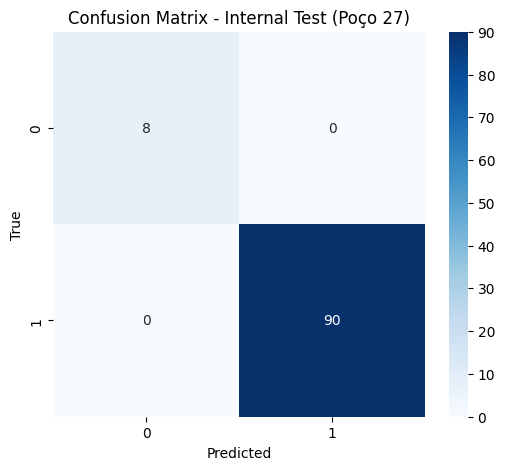

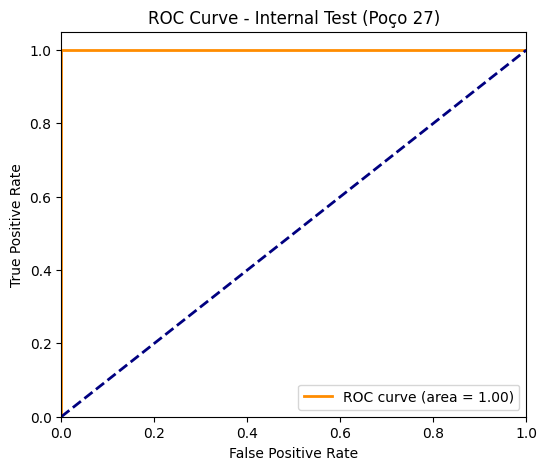

In [56]:
# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Internal Test (Poço 27)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
meta_test_proba = meta_clf.predict_proba(X_meta_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, meta_test_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Internal Test (Poço 27)")
plt.legend(loc="lower right")
plt.show()

## Validação Externa com Dados do Poço 28

Geramos as predições dos modelos base para o conjunto de validação (Poço 28), empilhamos e usamos o meta-classificador.



In [45]:
rf_val_preds = rf_clf.predict_proba(X_well28_pca)[:,1].reshape(-1,1)
gb_val_preds = gb_clf.predict_proba(X_well28_pca)[:,1].reshape(-1,1)
lstm_val_preds = lstm_clf.predict_proba(X_well28_pca)[:,1].reshape(-1,1)
X_meta_val = np.hstack([rf_val_preds, gb_val_preds, lstm_val_preds])
final_val_preds = meta_clf.predict(X_meta_val)

f1_val = f1_score(target_well28, final_val_preds)
accuracy_val = accuracy_score(target_well28, final_val_preds)
roc_auc_val = roc_auc_score(target_well28, meta_clf.predict_proba(X_meta_val)[:,1])
cm_val = confusion_matrix(target_well28, final_val_preds)

print("\n### Métricas de Validação (Poço 28)")
print("Acurácia:", accuracy_val)
print("F1 Score:", f1_val)
print("ROC AUC:", roc_auc_val)
print("Matriz de Confusão:\n", cm_val)

tn_v, fp_v, fn_v, tp_v = cm_val.ravel()
specificity_val = tn_v / (tn_v + fp_v) if (tn_v + fp_v) != 0 else 0
far_val = fp_v / (tn_v + fp_v) if (tn_v + fp_v) != 0 else 0
print("Especificidade (SPE):", specificity_val)
print("Taxa de Falsos Alarmes (FAR):", far_val)


### Métricas de Validação (Poço 28)
Acurácia: 0.8506493506493507
F1 Score: 0.915129151291513
ROC AUC: 0.9511019283746557
Matriz de Confusão:
 [[  7  15]
 [  8 124]]
Especificidade (SPE): 0.3181818181818182
Taxa de Falsos Alarmes (FAR): 0.6818181818181818


Confusion Matrix e a ROC Curve para o conjunto de validação do Poço 28:

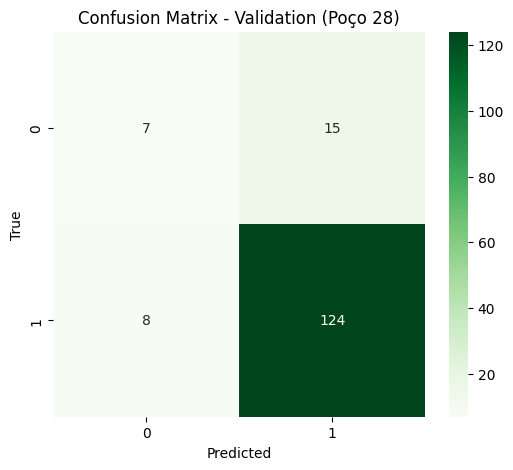

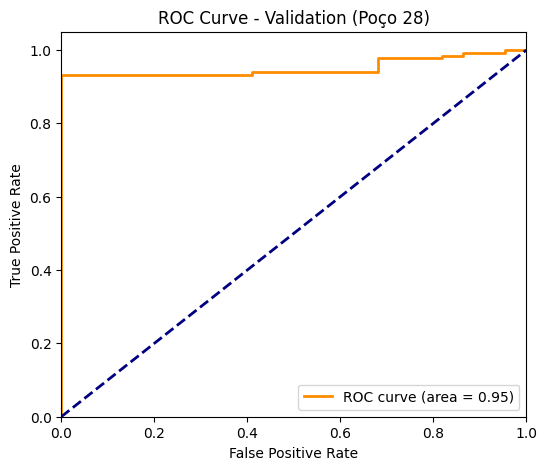

In [57]:
# Confusion Matrix - Validação
plt.figure(figsize=(6,5))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Validation (Poço 28)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve - Validação
meta_val_proba = meta_clf.predict_proba(X_meta_val)[:,1]
fpr_val, tpr_val, thresholds_val = roc_curve(target_well28, meta_val_proba)
roc_auc_val_value = auc(fpr_val, tpr_val)

plt.figure(figsize=(6,5))
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val_value:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation (Poço 28)")
plt.legend(loc="lower right")
plt.show()